# Notebook 5 - VSC for harmonic CO$_2$ in thermal equilibrium

### Initial Remark: 
#### To obtain the credit points for the UZH Polaritonic / QED chemistry lecture, please hand in a PDF report with your answers to this exercise by email. The report should not be longer than 3 computer written pages (including the figures). So please be concise! The deadline to hand in the report is Sunday, 4th of May. The answers will briefly be discussed during the lecture. To support collaborative research work, you are allowed to hand in joint reports. However, only two authors per report are allowed! 

The bare nuclear Hamiltonian of a single CO$_2$ molecule shall be given by

$$
    H^{i}_{\rm CO2}=\frac{P_{i1}^2}{2M_O} +\frac{P_{i2}^2}{2M_C} + \frac{P_{i3}^2}{2M_O} 
    +\frac{k_n}{2}(R_{i1}-R_{i2})^2
    +\frac{k_n}{2}(R_{i2}-R_{i3})^2,
$$

thus we neglect rotational excitations for simplicity. Furthermore, we have absorbed any bare matter contributions
from the original harmonic single electron-nuclear interaction into the inter-nucelear interactions to reach 
above simple form. The corresponding classical Hamiltonian equations of motion under VSC become,

$$
M_n\ddot{R}_{in} = 
-\frac{d}{dR_{in}} H^{i}_{\rm CO2}
+\bigg(Z_n - \frac{Z_e}{N_n}\bigg)E_\perp \\
\ddot{q}_{\alpha} = 
-\omega_\alpha^2 q_\alpha +\omega_\alpha (X+\langle x\rangle) .
$$

which can be determined analytically in the effective harmonic electron approximation. 

$$
E_\perp=\lambda ( \omega_\alpha q_\alpha - X -\langle x\rangle)\\
  \langle x\rangle=-\gamma^{2}\bigg(\frac{\lambda Z_e}{N_n}\sum_{i=1}^N\sum_{n=1}^{N_n}R_{in}-
\frac{\lambda^2 Z_e^2 N}{N_n k_e} X 
    +\frac{\lambda^2 Z_e^2 N}{N_n k_e}\omega_\beta q_\alpha\bigg).\\
\gamma^2=\frac{1}{1+\frac{\lambda^2 Z_e^2 N}{N_n k_e}}
$$

In a next step, we employ classical canonical equilibrium conditions by weakly coupling our ensemble 
to a thermal bath at temperature $T$. The resulting classical Langevin equations of motion are given by,

$$
M_n\ddot{R}_{in} = 
-\frac{d}{dR_{in}} H^{i}_{\rm CO2}
+\bigg(Z_n - \frac{Z_e}{N_n}\bigg)E_\perp - \gamma_T M_n\dot{R}_{in} + \sqrt{2 M_n \gamma_T k_B T}S_{in} \\
\ddot{q}_{\alpha} = 
-\omega_\alpha^2 q_\alpha +\omega_\alpha (X+\langle x\rangle) - \gamma_T \dot{q}_{\alpha} + \sqrt{2 \gamma_T k_B T}S_{\alpha}\\
\langle S_{in}(t)\rangle =0 \\
\langle S_{in}(t)S_{in}(t^\prime)\rangle =\delta(t-t^\prime)
$$
with friction coefficient $\gamma_T$.


# Bare matter parameters for MD simulation at constant temperature
In a next step, we explore our strongly coupled molecular ensemble at constant temperature numerically. 
For this purpose we have to choose resonable parameters (reasonable default values are commented in brackets). Below some resonable parameter are suggested for the harmonic CO2 ensembles that can be kept fixed during the different simulations. 

In [1]:
import warnings
import numpy as np
from scipy.special import erf
from matplotlib import pyplot as plt
import sys
import os
import datetime
from timeit import default_timer as timer
from statistics import variance, mean
import random
from scipy import signal
#from scipy.signal import blackman
from scipy.stats import moment# Fixed (recommended) simulation parameters
# Bare matter parameters
w_n_a = 0.0116 # asymmetric bare matter stretch mode CO2: 2565 cm-1 = 0.0116 H
m_c = 21874 #[me] carbon atom mass 12 u = 21874 me
m_o = 29166 #[me] oxygen atom mass 16 u = 29166 me

# bare matter parameters relevant inside cavity
k_e = 1 # electron-nuclear force constant
z_c = 1 # carbon nuclear charge number
z_o = 2 # oxygen nuclear charge number
m_e = 1 # effective electron mass (set to one, otherwise update eom)
z_e = 2 * z_o + z_c # effective electron charge number (neutral molecule)
m_vec = np.array([m_o,m_c,m_o])
z_vec = np.array([z_o,z_c,z_o])
k_n = w_n_a**2*(m_o*m_c)/(2*m_o+m_c) # approx 1, inter-nuclear force constant determined from IR active eigenmode mode (asymetric)
print('k_n = ',k_n)
w_n_s = np.sqrt(k_n/m_o) # determine symmetric stretch mode frequency of our model.

# Thermal bath parameter
gamma_T = 0.000005 # thermostat damping (small: weak coupling, large: Brownian motion)

# Numerical parameter
dt = 20 # integration timestep
equi_frac = 0.1 # equilibration for spectra calculation (discards first di_equi fraction of data points)


k_n =  1.0703213777403187


# MD simulation class
The following code propagates the Langevin equations of motion in time, which implicitly uses the analytically known forces of the dressed electronic structure problem, which significantly speeds up the simulation.

In [2]:
class VSCSim:
    def __init__(self,n,kBT,n_dt,l_c,w_c): # Initialize initial conditions and data containers
        # initialize variable simulation parameters
        self.n = n
        self.kBT = kBT
        self.n_dt = n_dt
        self.l_c = l_c
        self.w_c = w_c
          
        self.gamma2 = 1.0 / (1+ ((l_c * z_e)**2 * n / (3 * k_e)))
        
        
        #integrator parameters
        self.m_array = np.tile(m_vec,(n,1))
        self.z_array = np.tile(z_vec,(n,1))
        self.c_n1 = np.exp(-gamma_T*dt/2)*np.ones((n,3)) 
        self.c_n2 = np.sqrt(1.0-self.c_n1*self.c_n1)*np.sqrt(self.m_array*kBT)
        self.c_q1 = np.exp(-gamma_T*dt/2) # for simplicity same friction for displacement field as nuclei
        self.c_q2 = np.sqrt(1.0-self.c_q1*self.c_q1)*np.sqrt(kBT)
        
        
        # initialize minimum energy positions R_i=q=r_i=0 for simplicity, but non-zero (random) thermal momentum.
        # positions
        self.r_n_vec = np.zeros((n,3))
        self.r_e_vec = np.zeros(n)
        self.q = 0
        
        # momenta
        self.p_n_vec = np.sqrt(2.0*kBT*m_vec)*np.random.randn(n,3) #initially gamma_T=1 set
        self.pn_tplus = np.zeros((n,3))
        self.pn_tplusdelta = np.zeros((n,3))
         
        self.p_c = np.sqrt(2.0*kBT)*np.random.randn(1)[0] #initially gamma_T=1 set
        self.pq_tplus = 0
        self.pq_tplusdelta = 0 
        
        # data recorded
        self.traj_r_n = np.zeros((n_dt,n,3))
        self.traj_p_n = np.zeros((n_dt,n,3))
        #self.v_n = []
        self.traj_q = np.zeros(n_dt)
        self.traj_p_c = np.zeros(n_dt)
        self.traj_e = np.zeros((n_dt,n))
        self.traj_E_trans = np.zeros(n_dt)
        self.traj_dip_n = np.zeros((n_dt,n))
        self.traj_dip_e = np.zeros((n_dt,n))
        
        self.traj_r_n_tot = np.zeros(n_dt) 
        self.traj_x_n_tot = np.zeros(n_dt)
        self.traj_r_e_tot = np.zeros(n_dt)
        self.traj_x_e_tot = np.zeros(n_dt)
        self.traj_dip_n_tot = np.zeros(n_dt)
        self.traj_dip_e_tot = np.zeros(n_dt)
        self.force_n = np.zeros((n_dt,n,3))
        self.force_q = []
        self.traj_Epot_m = np.zeros((n_dt,n))
        self.traj_Ekin_m = np.zeros((n_dt,n))
        
        self.force_nu_vec = np.zeros((n,3))
        self.force_cav = 0
        self.E_trans = 0
        self.r_n_tot = 0
        self.r_e_tot = 0
        self.x_n_tot = 0
        self.x_e_tot = 0

# Implementation of Langevin equations of motion

    def classic_propagation_T(self,t):   
        # Numerical integration scheme see ref: https://journals.aps.org/pre/abstract/10.1103/PhysRevE.75.056707
        
        # Position calculations
        # nuclei 
        self.pn_tplus = self.c_n1*self.p_n_vec + self.c_n2*np.random.randn(self.n,3) 
        self.r_n_vec = self.r_n_vec + self.pn_tplus*dt/self.m_array + 0.5*self.force_nu_vec*dt**2/self.m_array
        self.r_n_tot = np.sum(self.r_n_vec) 
        self.dip_n_vec = np.sum(self.r_n_vec*self.z_array, axis=1)
        self.dip_n_tot = np.sum(self.dip_n_vec)
        self.x_n_tot = self.l_c*self.dip_n_tot
        self.pn_tplusdelta = self.pn_tplus+0.5*self.force_nu_vec*dt 
        
        # displacement field
        self.pq_tplus = self.c_q1*self.p_c+ self.c_q2*np.random.randn(1)[0]
        #print(self.c_q1,self.c_q2,"cq")
        self.q = self.q + self.pq_tplus*dt + 0.5*self.force_cav*dt**2
        self.pq_tplusdelta = self.pq_tplus + 0.5*self.force_cav*dt
        
        # update electronic positions using exact relation to nuclear and displacement field coordinates.
        self.r_e_tot = self.gamma2 * ((1 / 3) * np.sum(self.r_n_vec) - \
                                      (self.l_c * z_e) * self.n / (3 * k_e)*(-self.x_n_tot + self.w_c * self.q))
        self.dip_e_tot = -z_e*self.r_e_tot
        
        self.x_e_tot = self.l_c*self.dip_e_tot
        
        self.E_trans = self.l_c * (self.w_c* self.q-self.x_n_tot-self.x_e_tot) # transverse E-field definition
        self.r_e_vec = 1.0/3.0 * (np.sum(self.r_n_vec, axis=1) - self.E_trans * z_e / k_e*np.ones(self.n)) # analytic solution of electronic problem
        self.dip_e_vec = -z_e*self.r_e_vec
        
        # force and momentum calculations
        # bare matter nuclear forces
        force_m = np.transpose(np.array([-k_n*(self.r_n_vec[:,0]-self.r_n_vec[:,1]), # bare matter force acting on n 1st O nuclei
                            k_n*((self.r_n_vec[:,0]-self.r_n_vec[:,1])-(self.r_n_vec[:,1]-self.r_n_vec[:,2])),  # bare matter force acting on n C nuclei
                            k_n*(self.r_n_vec[:,1]-self.r_n_vec[:,2])])) # bare matter force acting on n 2nd O nuclei

        # coupling to cavity
        force_c=(self.z_array-(z_e/3)*np.ones((self.n,3)))*self.E_trans 
        self.force_nu_vec = force_m + force_c
        
        self.pn_tplusdelta = self.pn_tplusdelta + 0.5*self.force_nu_vec*dt 
        self.p_n_vec = self.c_n1*self.pn_tplusdelta + self.c_n2*np.random.randn(self.n,3)
        
        # displacement field force
        self.force_cav = -((self.w_c)**2*self.q - self.w_c*(self.x_n_tot + self.x_e_tot)) 
        self.pq_tplusdelta = self.pq_tplusdelta + 0.5*self.force_cav*dt #add new part of force
        self.p_c = self.c_q1*self.pq_tplusdelta + self.c_q2*np.random.randn(1)[0]
        
        # track some observables
        self.traj_r_n[t] = self.r_n_vec
        self.traj_p_n[t] = self.p_n_vec 
        self.traj_q[t] = self.q
        self.traj_p_c[t] = self.p_c
        self.traj_e[t] = self.r_e_vec
        self.traj_E_trans[t] = self.E_trans
        self.traj_x_n_tot[t] = self.x_n_tot
        self.traj_r_n_tot[t] = self.r_n_tot   
        self.traj_x_e_tot[t] = self.x_e_tot 
        self.traj_r_e_tot[t] = self.r_e_tot
        self.traj_dip_n[t] = self.dip_n_vec
        self.traj_dip_n_tot[t] = self.dip_n_tot
        self.traj_dip_e[t] = self.dip_e_vec
        self.traj_dip_e_tot[t] = self.dip_e_tot
        
        # bare matter energies
        Epot_m_vec = k_n / 2 * ((self.r_n_vec[:,0]-self.r_n_vec[:,1])**2 + (self.r_n_vec[:,1]-self.r_n_vec[:,2])**2)
        
        self.traj_Epot_m[t] = Epot_m_vec
        #self.traj_Epot_m_tot[t] = np.sum(Epot_m_vec)
        Ekin_m_vec = np.sum(self.p_n_vec**2 / (2*self.m_array), axis=1)
        self.traj_Ekin_m[t] = Ekin_m_vec
        #self.traj_Ekin_m_tot[t] =np.sum(Ekin_m_vec)


# Q10.1.1 Run bare matter MD simulation ($\lambda=0$)


In [3]:
# Variable (recommended) Simulation parameters to explore 
n_molecules = 20 # number of CO2 molecules in ensemble
kBT_ensemble = 0.001 # [H] temperature (should be related to vibrational modes)
n_timesteps = 300000 # > 100000 number of timesteps for propagation

lambda_alpha = 0.0 # cavity coupling constant
omega_alpha = 0.0 # cavity resonance frequency (take e.g. resonance suggestions below)

# initialize MD simulation
molecules = VSCSim(n_molecules, kBT_ensemble ,n_timesteps, lambda_alpha, omega_alpha)

# run MD simulation
start = timer()
for i in range(n_timesteps):
    molecules.classic_propagation_T(i)
end = timer()    
print("elapsed time for simulation, without analysis: ",end - start)

elapsed time for simulation, without analysis:  12.051875708000011


# Data analysis and plotting class

In [4]:
class data_ana:
    def __init__(self, sim):
        self.sim = sim
        
        # analytically computed frequencies
        self.w_c_tilde = self.sim.w_c*np.sqrt(self.sim.gamma2)
        self.e_a2 = (2*m_o+m_c)*(z_c-z_o)**2/(3*m_c*m_o)
        self.w_n_a_tilde = np.sqrt(w_n_a**2+2*self.sim.n*self.e_a2*self.sim.l_c**2*self.sim.gamma2)
        self.ka_tilde = self.w_n_a_tilde**2

        
    def output_analytic_results(self):
        # Compute analytically known frequencies     
        print("w_n_s = ", w_n_s) # experimental symmetric bare matter stretch mode of CO2: 1480 cm-1 = 0.0067 H 
        print("gamma^2 = ",self.sim.gamma2)
        print("w_c_tilde = ",self.w_c_tilde)
        print("w_n_a_tilde = ",self.w_n_a_tilde)
        
   
    def plot_trajectories(self):
        # calculate energies
        fig =plt.figure(figsize=(12, 6), dpi=200)                       
        plt.title("Bare Matter Epot")
        plt.xlabel("time")
        plt.ylabel("Epot")
        time = np.arange(self.sim.n_dt)*dt  
        plt.plot(time, np.mean(self.sim.traj_Epot_m,axis=1), 'b-', label='Epot')
        plt.fill_between(time, np.mean(self.sim.traj_Epot_m,axis=1) - np.std(self.sim.traj_Epot_m,axis=1),
                         np.mean(self.sim.traj_Epot_m,axis=1) + np.std(self.sim.traj_Epot_m,axis=1), color='b', alpha=0.2)
        #plt.plot(time, w_c * np.ones(n_dt), 'k', label='$w_c$')
        #plt.legend()
        plt.savefig( "./Epot_t_kBT_"+str(self.sim.kBT)+"_N_"+str(self.sim.n)+"_lc_"+str(self.sim.l_c)+"_wc_"+str(self.sim.w_c)+".png")
        plt.show()
        plt.close(fig)
        
        fig =plt.figure(figsize=(12, 6), dpi=200) 
        plt.title("Bare Matter Ekin")
        plt.xlabel("time")
        plt.ylabel("Ekin")  
        plt.plot(time, np.mean(self.sim.traj_Ekin_m,axis=1), 'r-', label='Ekin')
        plt.fill_between(time, np.mean(self.sim.traj_Ekin_m,axis=1) - np.std(self.sim.traj_Ekin_m,axis=1),
                         np.mean(self.sim.traj_Ekin_m,axis=1) + np.std(self.sim.traj_Ekin_m,axis=1), color='r', alpha=0.2)
        plt.plot(time, 3*self.sim.kBT/2 * np.ones(self.sim.n_dt), 'k-', label='$3 k_B T/2$')
        #plt.plot(time, w_c * np.ones(n_dt), 'k', label='$w_c$')
        plt.legend()
        plt.savefig( "./Ekin_t_kBT_"+str(self.sim.kBT)+"_N_"+str(self.sim.n)+"_lc_"+str(self.sim.l_c)+"_wc_"+str(self.sim.w_c)+".png")
        plt.show()
        plt.close(fig)
        
    def plot_spectra(self):
        # follow powerspec method in https://aip.scitation.org/doi/pdf/10.1063/1.441739
        print("calculate IR absorption spectrum from dipole autocorrelation")
        
        dipole_n_e_t = self.sim.traj_dip_n_tot+self.sim.traj_dip_e_tot
        dipole_n_e_t_loc = self.sim.traj_dip_n+self.sim.traj_dip_e
        dist_CO1_loc = self.sim.traj_r_n[:,:,0]-self.sim.traj_r_n[:,:,1]
        
        # prepare averaging and windowing for blackman filter:
        # https://ccrma.stanford.edu/~jos/sasp/Welch_s_Method_Windows.html
        #ensures equilibrated data of length 2**n
        di_equi = int(equi_frac*self.sim.n_dt)
        N_sign = self.sim.n_dt - di_equi
        #window_resolution = libqed.config.getfloat("csm_dynamics", "window_resolution") adjust
        omega_min_guess = 0.000004 #0.006/window_resolution adjust

        M_window = int(2*np.pi/(omega_min_guess*dt))#must be much larger than lowest frequency chose 20
        M_window_2n = 2 ** np.floor(np.log2(((M_window) - 1))).astype('int')
        omega_min = 2*np.pi/(M_window_2n*dt)
        print("omega_min",omega_min," omega_min_guess ", omega_min_guess)
        R_hopp = int(1/3 * M_window_2n) #optimal for blackman filter
        K_window = int((N_sign-M_window_2n)/R_hopp)+1
        print("M_window",M_window,"M_window_2n",M_window_2n,"R_hopp",R_hopp,"K_window",K_window)
        #size = 2 ** np.floor(np.log2(((len(dipole_n_e_t)-di_equi) - 1))).astype('int')

        #prepare blackmann window to filter data for fft 
        w_black = signal.windows.blackman(M_window_2n) #blackman(M_window_2n)

        
        k_vec = np.linspace(-M_window_2n/2+1, M_window_2n/2-1,M_window_2n-1)
        #print("k_vec", k_vec,len(k_vec))
        omega_abs = 2*np.pi/(M_window_2n) * k_vec/dt # notice the dt acting on omega from t=dt*i

        #filter for lowes frequency, neglect negative frequencies (should be symmetric)
        omega_filter_idx = np.where(omega_abs>omega_min*8)
        #print("omega_filter_idx",omega_filter_idx,len(omega_filter_idx[0]))
        omega_abs = omega_abs[omega_filter_idx]
    
        # averge over over different t0 offsets
        
        
        # calculate collective autocorr
        autocorrtot_omega = 0
        etrans_autocorr = 0
        for i in range(0,K_window):
            # absorption
            sig_shifted = dipole_n_e_t[(di_equi+i*R_hopp):(M_window_2n+di_equi+i*R_hopp)]
            autocorrtot_omega = autocorrtot_omega + 1/(M_window_2n*dt*K_window)* \
                np.abs(np.fft.fftshift(np.fft.fft(sig_shifted*w_black)/dt))**2
            # transverse E-field
            etrans_shifted = self.sim.traj_E_trans[(di_equi+i*R_hopp):(M_window_2n+di_equi+i*R_hopp)]
            etrans_autocorr = etrans_autocorr + 1/(M_window_2n*dt*K_window)* \
                np.abs(np.fft.fftshift(np.fft.fft(etrans_shifted*w_black)/dt))**2
        
        autocorrtot_omega = autocorrtot_omega[omega_filter_idx] #only even contributions are considered
        absorption_T0 = omega_abs * autocorrtot_omega
        
        #etrans_autocorr = etrans_autocorr[omega_filter_idx] #only even contributions are considered
        #etrans_absorption_T0 = omega_abs * etrans_autocorr
        
        # calculate local autocorr
        autocorr_omega_loc = []
        CO1autocorr_omega_loc = []
        for j in range(0,self.sim.n):
            sig_shifted = dipole_n_e_t_loc[(di_equi):(M_window_2n+di_equi),j]
            aolj = 1/(M_window_2n*dt*K_window)* \
                    np.abs(np.fft.fftshift(np.fft.fft(sig_shifted*w_black)/dt))**2
            for i in range(1,K_window):
                sig_shifted = dipole_n_e_t_loc[(di_equi+i*R_hopp):(M_window_2n+di_equi+i*R_hopp),j]
                aolj = aolj + 1/(M_window_2n*dt*K_window)* \
                    np.abs(np.fft.fftshift(np.fft.fft(sig_shifted*w_black)/dt))**2
            autocorr_omega_loc.append(aolj[omega_filter_idx]) #only even contributions are considered
            
            # CO Distance
            CO1sig_shifted = dist_CO1_loc[(di_equi):(M_window_2n+di_equi),j]
            CO1aolj = 1/(M_window_2n*dt*K_window)* \
                    np.abs(np.fft.fftshift(np.fft.fft(CO1sig_shifted*w_black)/dt))**2
            for i in range(1,K_window):
                CO1sig_shifted = dist_CO1_loc[(di_equi+i*R_hopp):(M_window_2n+di_equi+i*R_hopp),j]
                CO1aolj = CO1aolj + 1/(M_window_2n*dt*K_window)* \
                    np.abs(np.fft.fftshift(np.fft.fft(CO1sig_shifted*w_black)/dt))**2
            CO1autocorr_omega_loc.append(CO1aolj[omega_filter_idx]) #only even contributions are considered
        
        autocorr_omega_loc = np.array(autocorr_omega_loc)
        absorption_T0_loc = omega_abs * autocorr_omega_loc
        
        CO1autocorr_omega_loc = np.array(CO1autocorr_omega_loc)
        CO1absorption_T0_loc = omega_abs * CO1autocorr_omega_loc
        

        ### Plot absoprtion data ###
        fig = plt.figure(figsize=(12, 6), dpi=200)
        plt.title("Spectra")
        plt.xlabel("$\omega$ , a.u.")
        plt.ylabel("Resonances")
        plt.grid(True)
        plt.yscale('log')
        plt.xlim(xmin=0.005,xmax=0.018)
        plt.plot(omega_abs, absorption_T0,color = 'r', label='total dipole resonances')
        plt.plot(omega_abs, np.mean(absorption_T0_loc, axis=0),color = 'b', label='local dipole resonances')
        plt.plot(omega_abs, np.mean(CO1absorption_T0_loc, axis=0),color = 'lime', label='CO bond resonances')

        try:
            plt.plot(np.ones(2)*w_n_s, [0,10*np.max(absorption_T0)], 'g',linestyle=':', label='$\omega_s$')
            plt.plot(np.ones(2)*w_n_a, [0,10*np.max(absorption_T0)], 'k',linestyle=':', label='$\omega_a$')
            plt.plot(np.ones(2) * self.w_n_a_tilde, [0,10*np.max(absorption_T0)], 'k',linestyle='-', label=r'$\tilde{\omega}_a$')

            plt.plot(np.ones(2)*self.sim.w_c, [0,10*np.max(absorption_T0)], 'y',linestyle=':', label=r'$\omega_{\alpha}$')
            plt.plot(np.ones(2)*self.w_c_tilde, [0,10*np.max(absorption_T0)], 'y',linestyle='-', label=r'$\tilde{\omega}_{\alpha}$')
        except:
            print("Analytical spectral values not yet initialized")
        finally:
            plt.legend(loc="upper right")
            plt.savefig( "./resonances_omega_kBT_"+str(self.sim.kBT)+"_N_"+str(self.sim.n)+"_lc_"+str(self.sim.l_c)+"_wc_"+str(self.sim.w_c)+".png")
            plt.show()
            plt.close(fig)
    


# Q10.1.2 Plotting bare matter properties
Explore bare matter simulation parameters in Q10.1.1. Get a feeling for the temperature and the simulation performance (with respect to number of molecules and duration). 

What do we learn from the bare matter potential energies and kinetic energies (mean value in bolt and standard deviation in light colors)? How do they depend on the esemble size $N$?

What is the difference between the different spectral lines (see code lines 54-56 in plot_spectra class)? 
Label them in the code lines 148-150.

What are the theoretical limits of the spectral resolution for the given simulation setup?

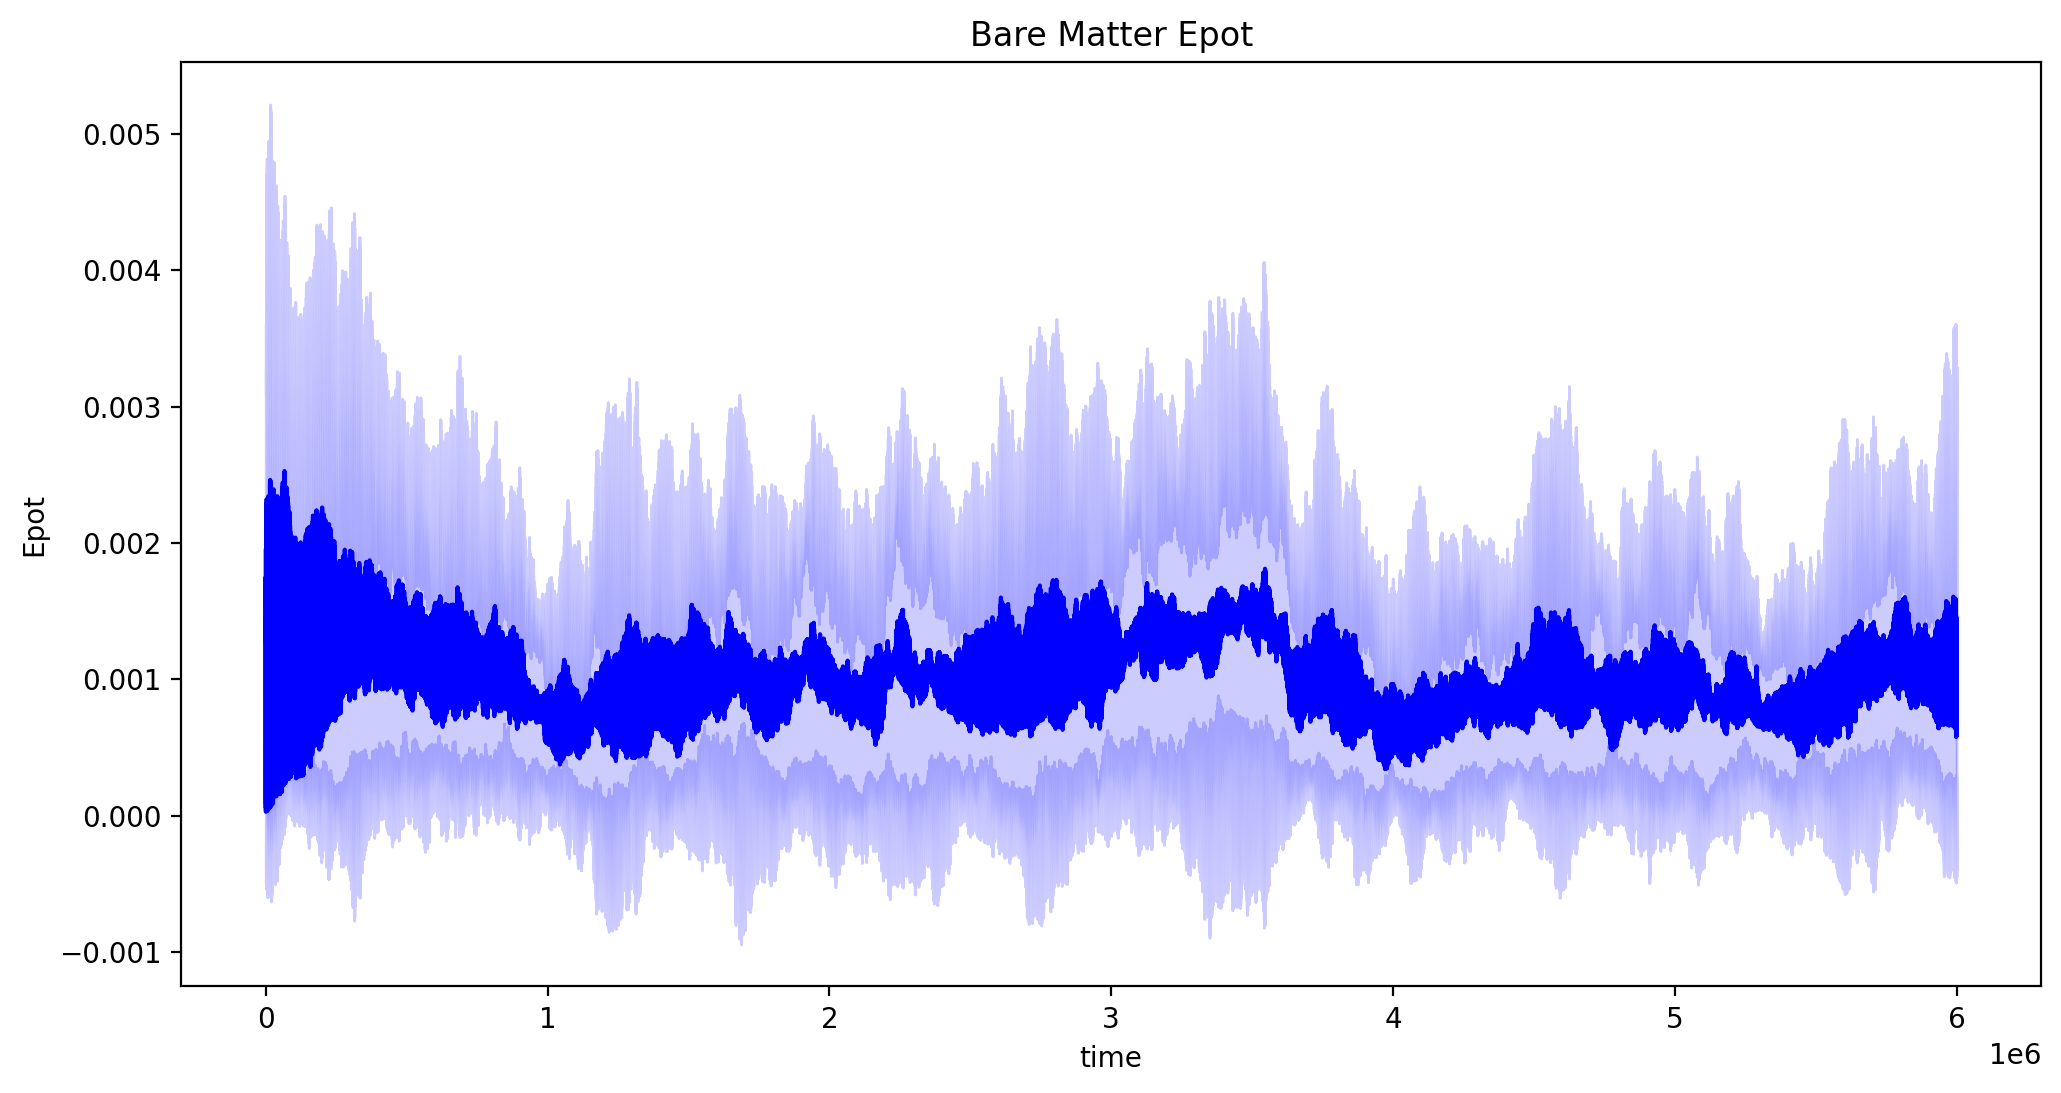

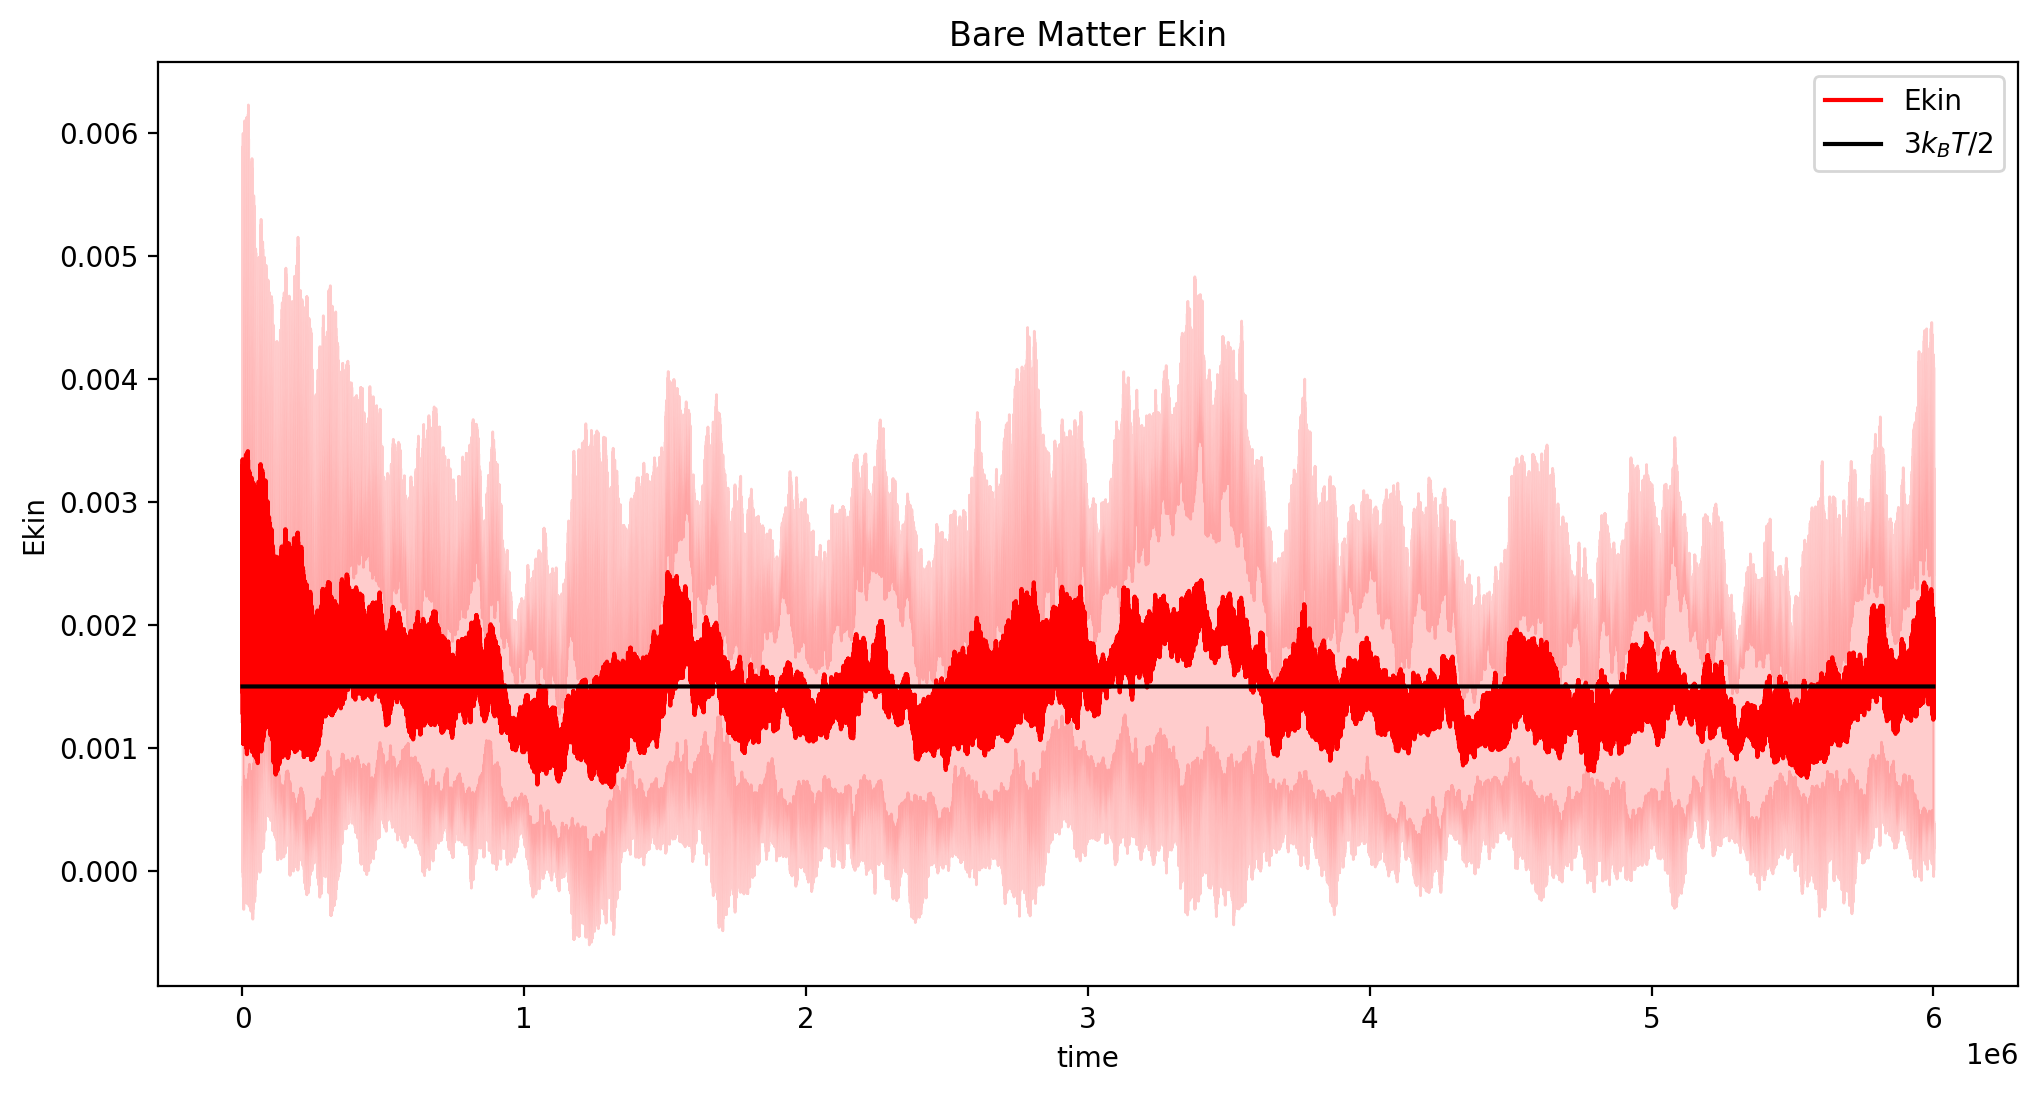

calculate IR absorption spectrum from dipole autocorrelation
omega_min 4.793689962142629e-06  omega_min_guess  4e-06
M_window 78539 M_window_2n 65536 R_hopp 21845 K_window 10


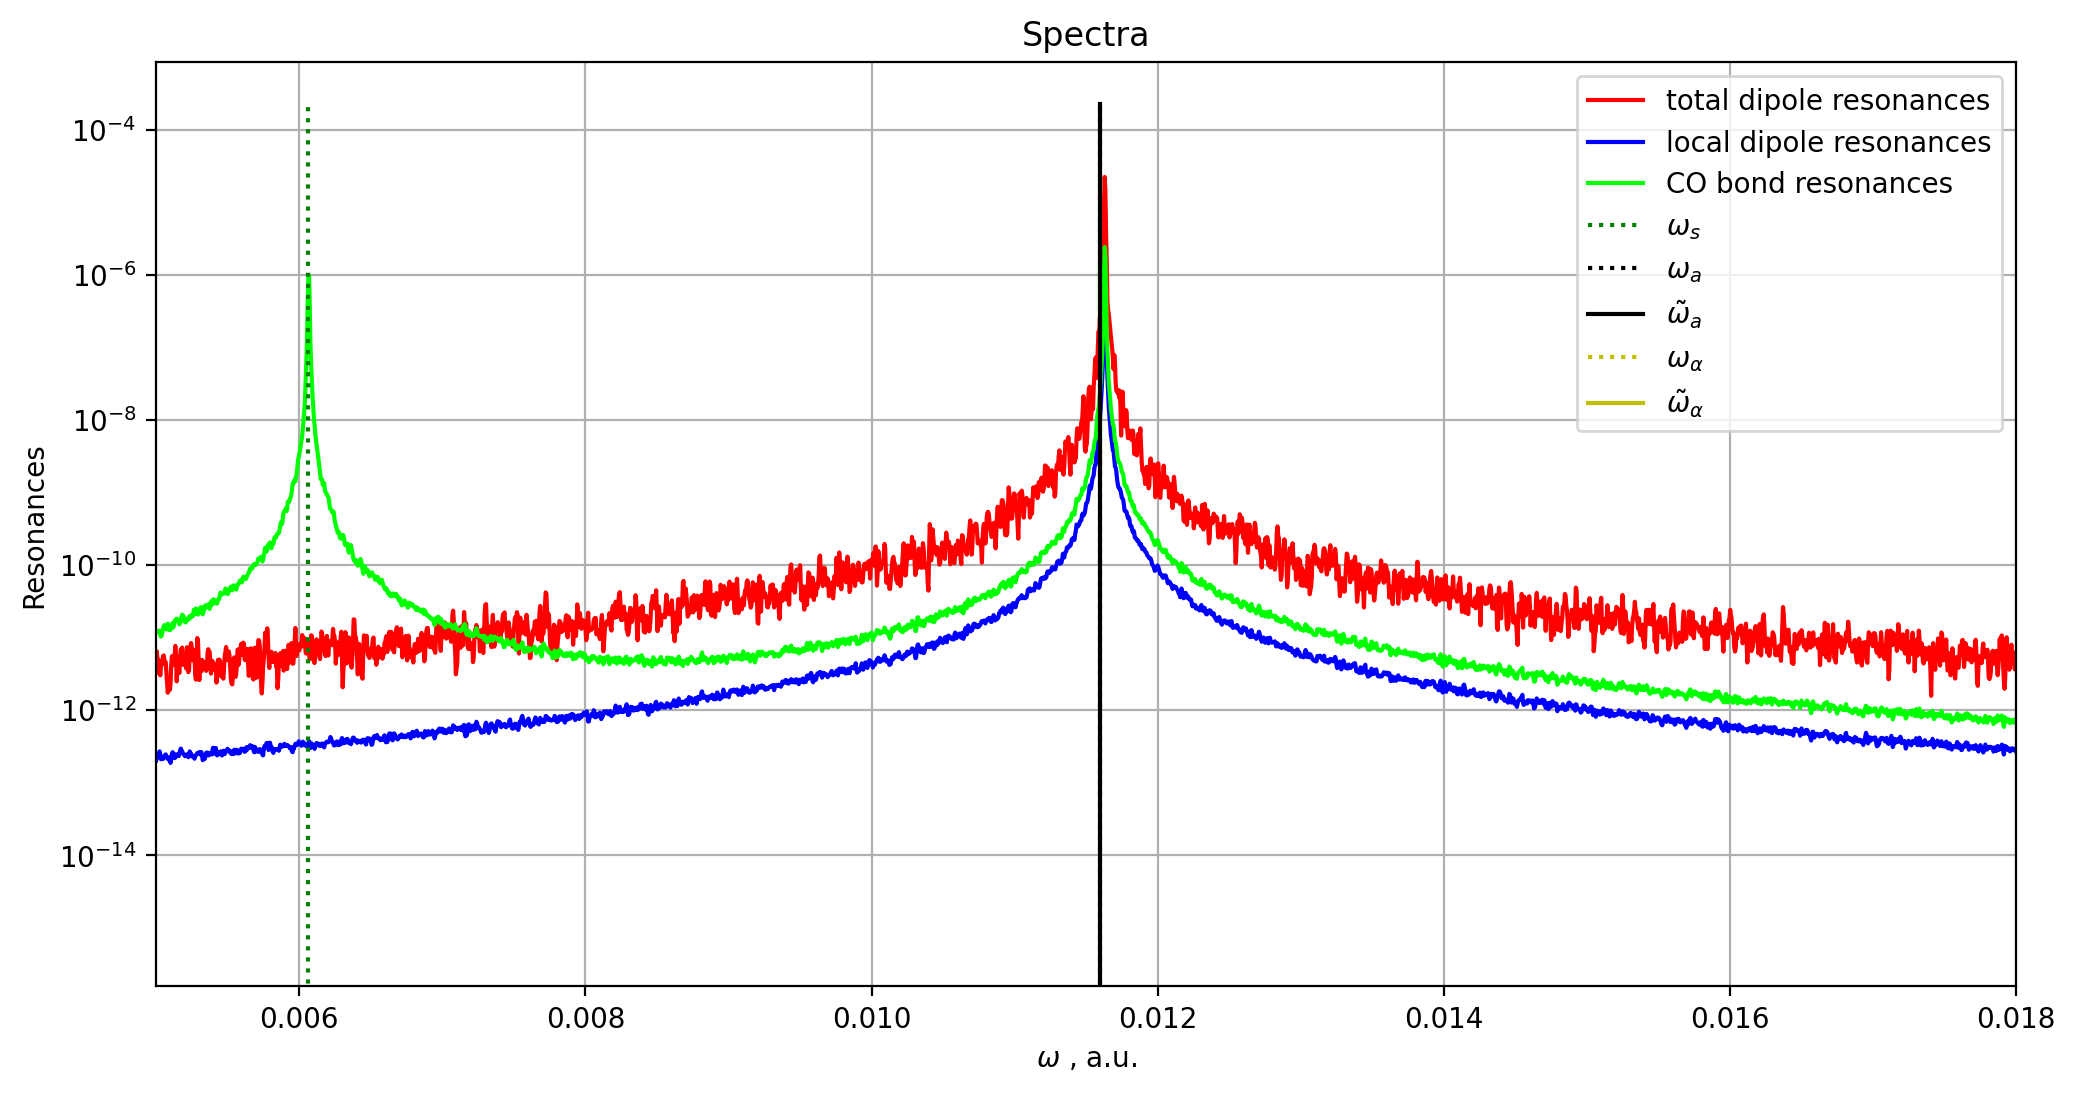

In [5]:
data = data_ana(molecules) # initialize data_ana object with simulated data
data.plot_trajectories() # plot energy trajectories
data.plot_spectra() # calculate spectral features

# A10.1
The mean energy values becomes constant with increasing ensemble size, while the fluctuations are determined by the temperature. Visual inspection reveals that the molecular ensemble reaches thermal equilibrium, while the losses of the thermostat are low enough to avoid Brownian motion, i.e., the thermostat is only weakly coupled to the system. The high-frequency limit of the spectra is determined by the minimum integration timestep ($\omega_{\rm max}=2\pi/(n_{\rm timesteps}\Delta t)$), while the duration of the simulation determines a lower bound for the spectrum ($\omega_{min}=\pi/\Delta t$, Nyquist theorem). Notice that our routine uses multiple windows and filter function to get a cleaner spectra, which further limits the low frequency resolution. The details are beyond the scope of this lecture. Furthermore, notice that the first 10% of the data points are discarded to allow for better equilibration and to reduce potential errors from the initialization procedure. 

 # Q10.2 Couple ensemble to a cavity ($\omega_\alpha=\omega_a$)
 Try to identify reasonable coupling parameters $\lambda$ and identify the spectral peaks. What do you notice?

Simulation started ... 
elapsed time for simulation, without analysis:  11.95312687500001
calculate IR absorption spectrum from dipole autocorrelation
omega_min 4.793689962142629e-06  omega_min_guess  4e-06
M_window 78539 M_window_2n 65536 R_hopp 21845 K_window 10


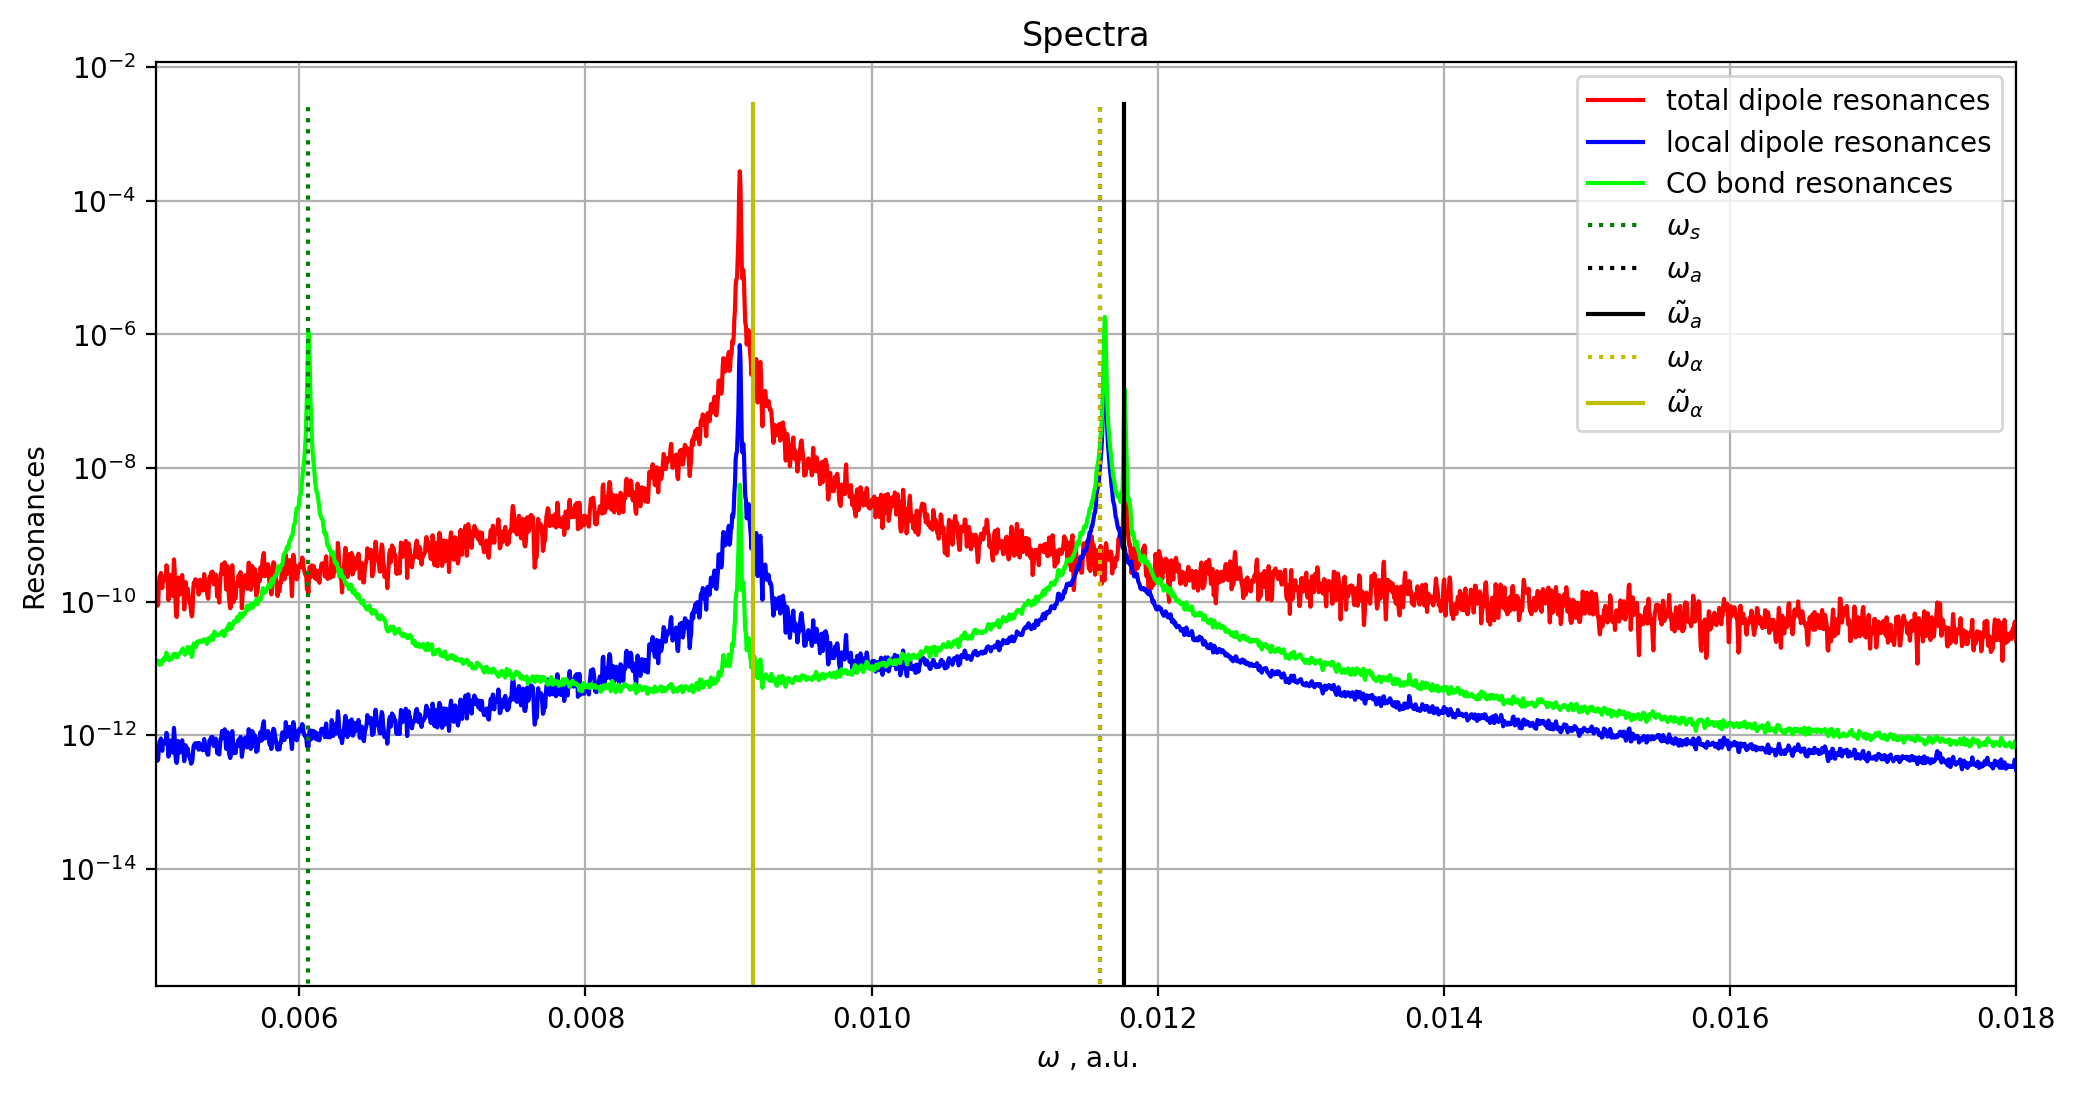

In [6]:
# Variable (recommended) Simulation parameters to explore 
n_molecules = 20 # number of CO2 molecules in ensemble
kBT_ensemble = 0.001 # [H] temperature (should be related to vibrational modes)
n_timesteps = 300000 # > 100000 number of timesteps to propagation

lambda_alpha = 0.06 # cavity coupling constant
omega_alpha = w_n_a # cavity resonance frequency (take e.g. resonance suggestions below)

# initialize MD simulation
print("Simulation started ... ")
molecules = VSCSim(n_molecules, kBT_ensemble ,n_timesteps, lambda_alpha, omega_alpha)

# run MD simulation
start = timer()
for i in range(n_timesteps):
    molecules.classic_propagation_T(i)
end = timer()    
print("elapsed time for simulation, without analysis: ",end - start)

# output data
data = data_ana(molecules)
#data.plot_trajectories()
data.plot_spectra()

# A10.2
A resonable coupling parameter is for example $\lambda=0.06$ for $N=20$. We can identify lower and upper polaritons that appears in the collective dipole fluctuations, which is strongly asymmetric (upper polariton is hardly visible) for $\omega_\alpha=\omega_a$. Furthermore, the single molecular measurements indicate the presence of many "dark" states, i.e. vibrations at the bare matter modes. Moreover, the upper and lower polaritonic peaks are also populated locally (single molecules), which indicate local molecular changes in the ensemble under collective VSC.

# Tune the cavity on resonance
## Analytical normal modes and resonances

As we have seen in the lecture slides, our classical equations of motion suggest different normal mode frequencies that are of phyical interest:

The bare matter asymmetric $\omega_a$ and symmetric $\omega_s$ stretch modes of harmonic CO$_2$ are given by
$$
\omega_a=\sqrt{k_a}=\sqrt{\frac{(2 M_O+M_C) k_n}{M_O M_C}}=0.0116 \\
\omega_s=\sqrt{k_s}=\sqrt{\frac{k_n}{M_O}}=0.00605,
$$
where $k_n$ and the masses are chosen to meet the experimental condition for the asymmetric mode, which then automatically determines the symmetric mode as well.
When coupling the normal mode transformed molecules to a cavity, we introduce the rescaled charge parameter
$$
\epsilon_{a} = \frac{\sqrt{M} {\left(Z_{C} - Z_{O}\right)}}{3 \, \sqrt{M_{C}} \sqrt{M_{O}}}.
$$
The polarization of the molecules inside the cavity introduce a redshift of the bare cavity frequency $\omega_c$ that can be written as 
$$
 \tilde{\omega}_{\alpha} =\gamma \omega_{\alpha},
$$
and directly related to the refractive index of the medium (see lecture). Similarly, the asymmetric (IR active)  matter frequency of the collective nuclear coordinates $R=\sum_i^N\sum_n R_{in}$ is blueshifted by 
$$
\tilde{\omega}_{a}^2 =\tilde{k}_a= \left(\omega_a^2 + 2N \epsilon_{\rm a}^2 \lambda^2 \gamma^2 \right).
$$


## Q10.3.1 Calculate analytic frequencies and spectra
Uncomment the frequencies in the __init__() function of the class data_ana() (and run the updated code) and compute the spectra below.

w_n_s =  0.0060578520741874095
gamma^2 =  0.625
w_c_tilde =  0.0091706052144883
w_n_a_tilde =  0.011761444531844608
calculate IR absorption spectrum from dipole autocorrelation
omega_min 4.793689962142629e-06  omega_min_guess  4e-06
M_window 78539 M_window_2n 65536 R_hopp 21845 K_window 10


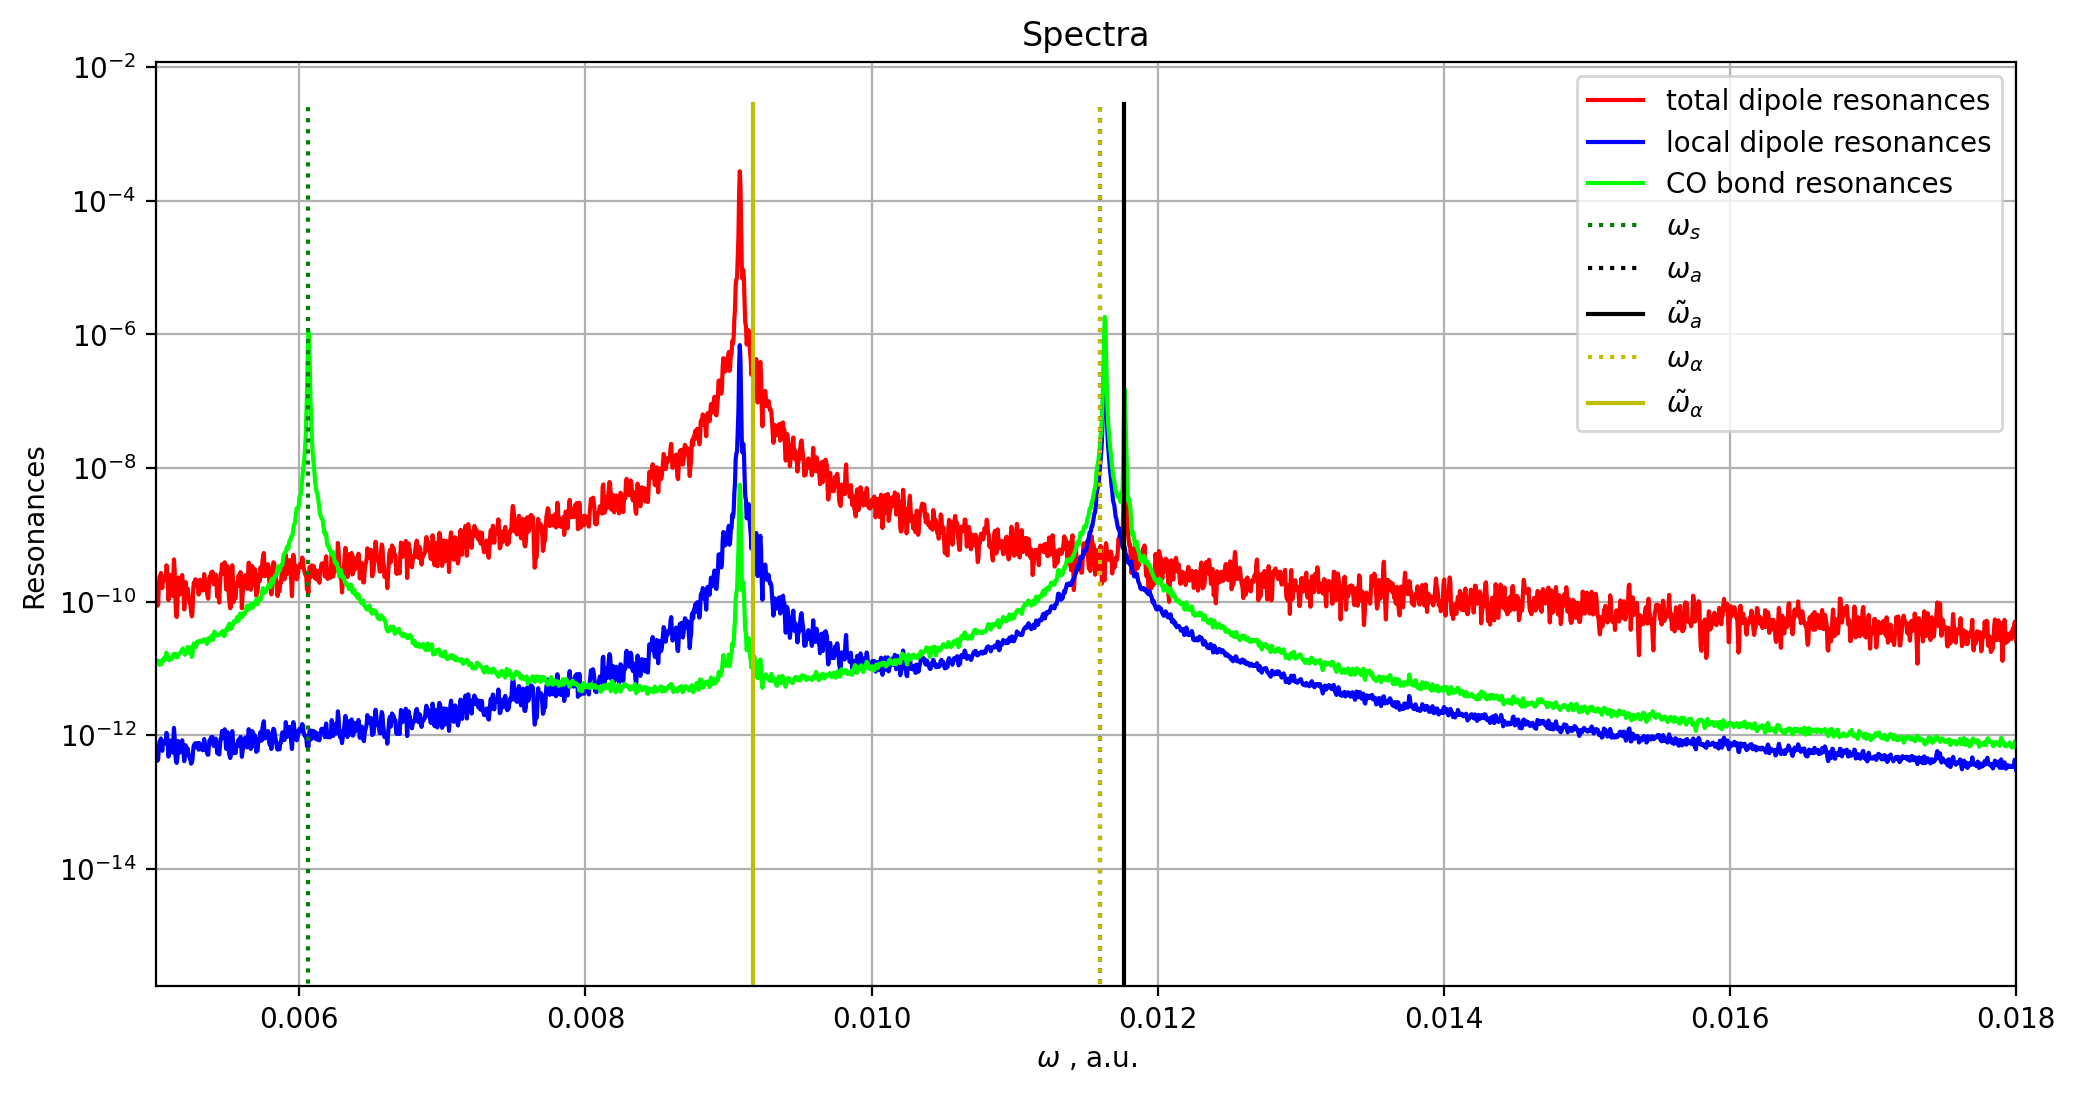

In [7]:
data = data_ana(molecules)
data.output_analytic_results()
data.plot_spectra()

# Q10.3.2 What does "on resonance" mean?
Which of the analytically caculated freuquencies shall be related to be "on resonance"? What could be a resonable definition for "on resonance" (remember the detuning of the Jaynes-Cummings model, how did the Rabi-splitting look like on resonance)? Explore these questions numerically by using the analytically known frequency definitions. 

Simulation started ... 
elapsed time for simulation, without analysis:  12.473004625000044
calculate IR absorption spectrum from dipole autocorrelation
omega_min 4.793689962142629e-06  omega_min_guess  4e-06
M_window 78539 M_window_2n 65536 R_hopp 21845 K_window 10


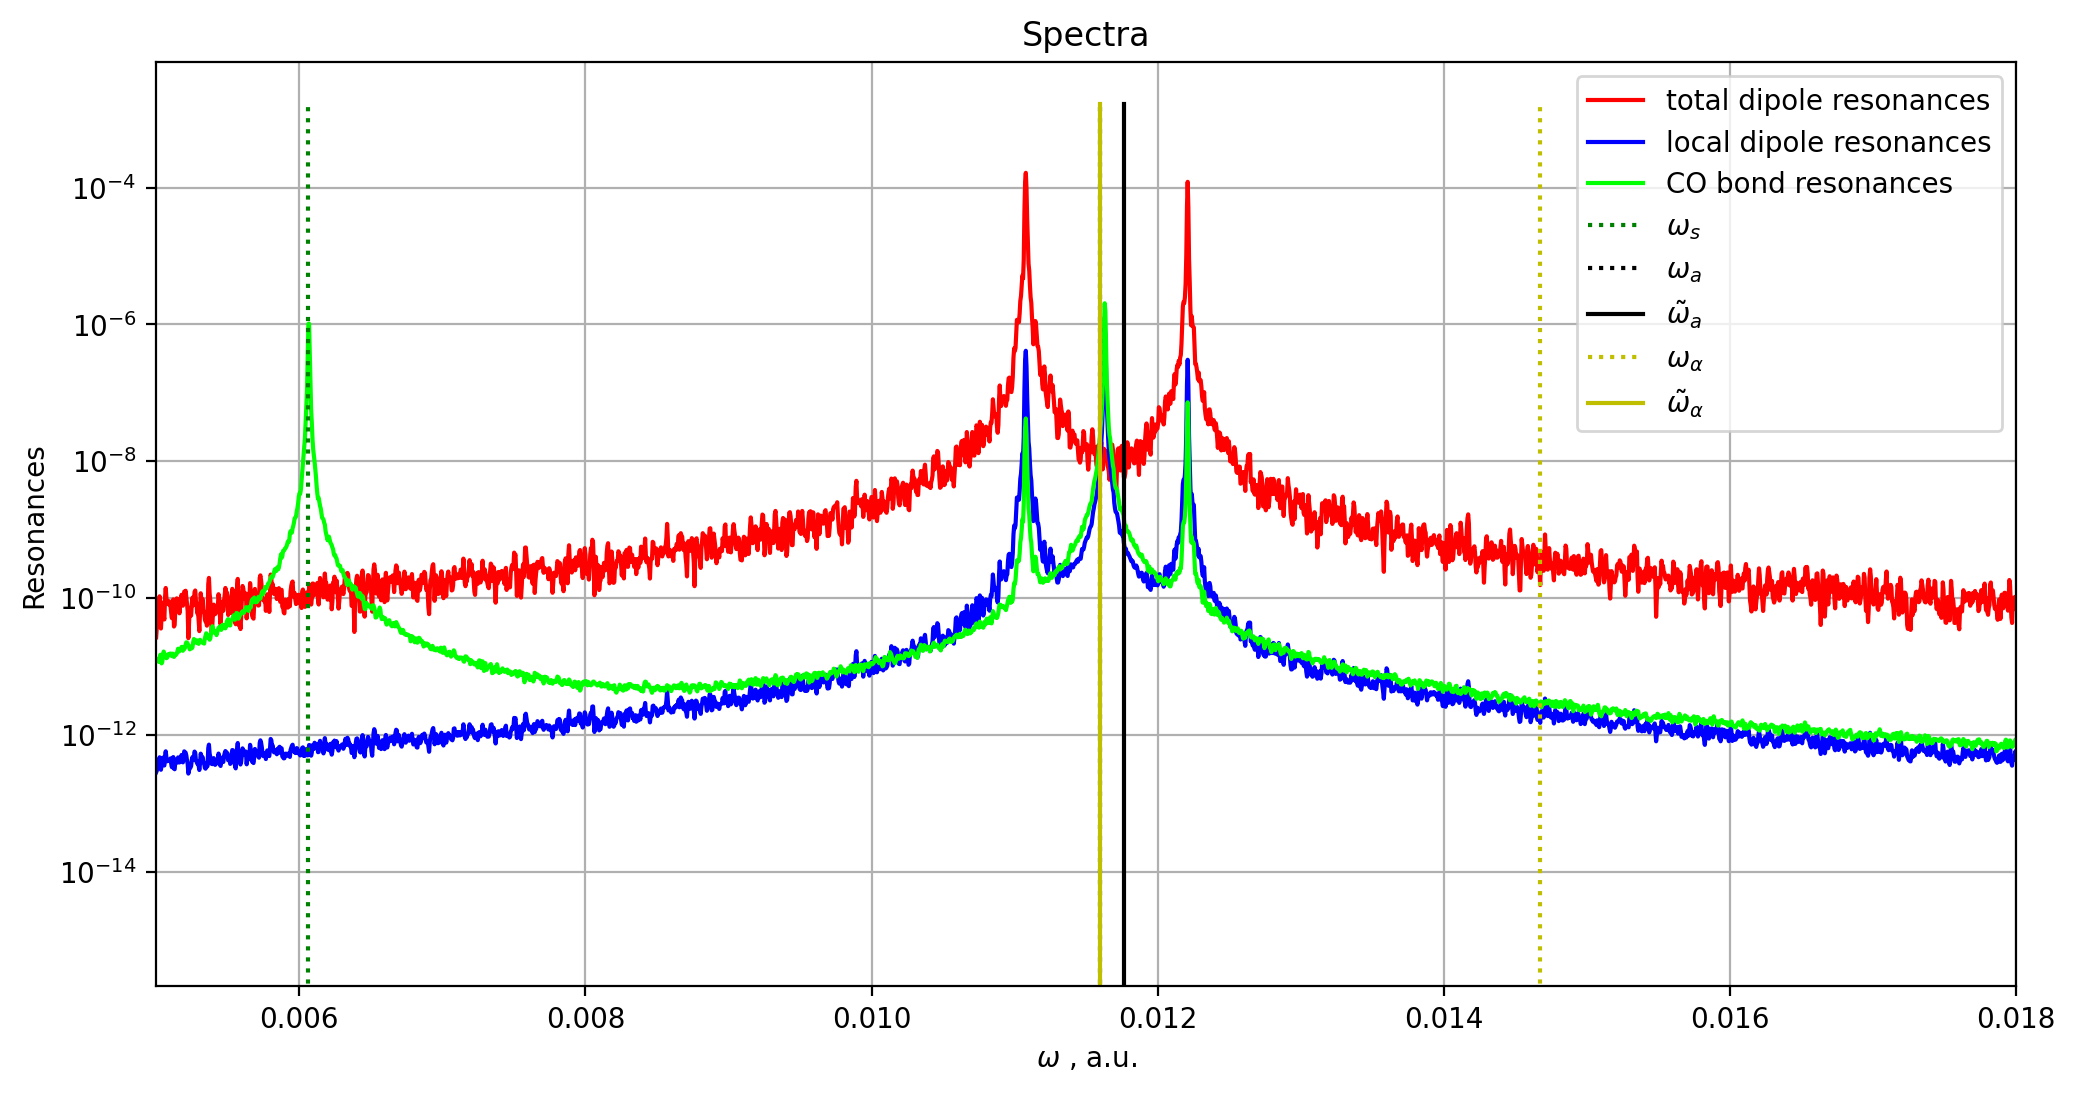

In [8]:
# todo: run your simulations
# Variable (recommended) Simulation parameters to explore 
n_molecules = 20 # number of CO2 molecules in ensemble
kBT_ensemble = 0.001 # [H] temperature (should be related to vibrational modes)
n_timesteps = 300000 # > 100000 number of timesteps to propagation

lambda_alpha = 0.06 # cavity coupling constant
omega_alpha =  0.014672 # cavity resonance frequency (take e.g. resonance suggestions below)

# initialize MD simulation
print("Simulation started ... ")
molecules = VSCSim(n_molecules, kBT_ensemble ,n_timesteps, lambda_alpha, omega_alpha)

# run MD simulation
start = timer()
for i in range(n_timesteps):
    molecules.classic_propagation_T(i)
end = timer()    
print("elapsed time for simulation, without analysis: ",end - start)

# output data
data = data_ana(molecules)
#data.plot_trajectories()
data.plot_spectra()

# A10.3.2 
A reasonable defintion of resonance frequency could for example be that the Rabi splitting is symmetric with respect to it.
The simulations seem to suggest that we reach this resonance condition for $\tilde{\omega_\alpha}=\omega_a$, i.e., when tuning the redshifted cavity frequency to the bare matter asymmetric stretch mode. The following simulation parameters should are for example tuned on resonance: $N = 20$, $kBT= 0.001$, $\lambda=0.06$, $\omega_\alpha=\frac{\omega_a}{\gamma}= 0.014672$.

# Q10.4 Collective vs. local strong coupling mystery
What do you observe when increasing the number of molecules while keeping the collective Rabi splitting (roughly) constant? Remember the Tavis-Cummings model to help you choose resonable input parameters to efficiently reach this goal!

Simulation started ... 
elapsed time for simulation, without analysis:  26.397944332999998
calculate IR absorption spectrum from dipole autocorrelation
omega_min 4.793689962142629e-06  omega_min_guess  4e-06
M_window 78539 M_window_2n 65536 R_hopp 21845 K_window 10


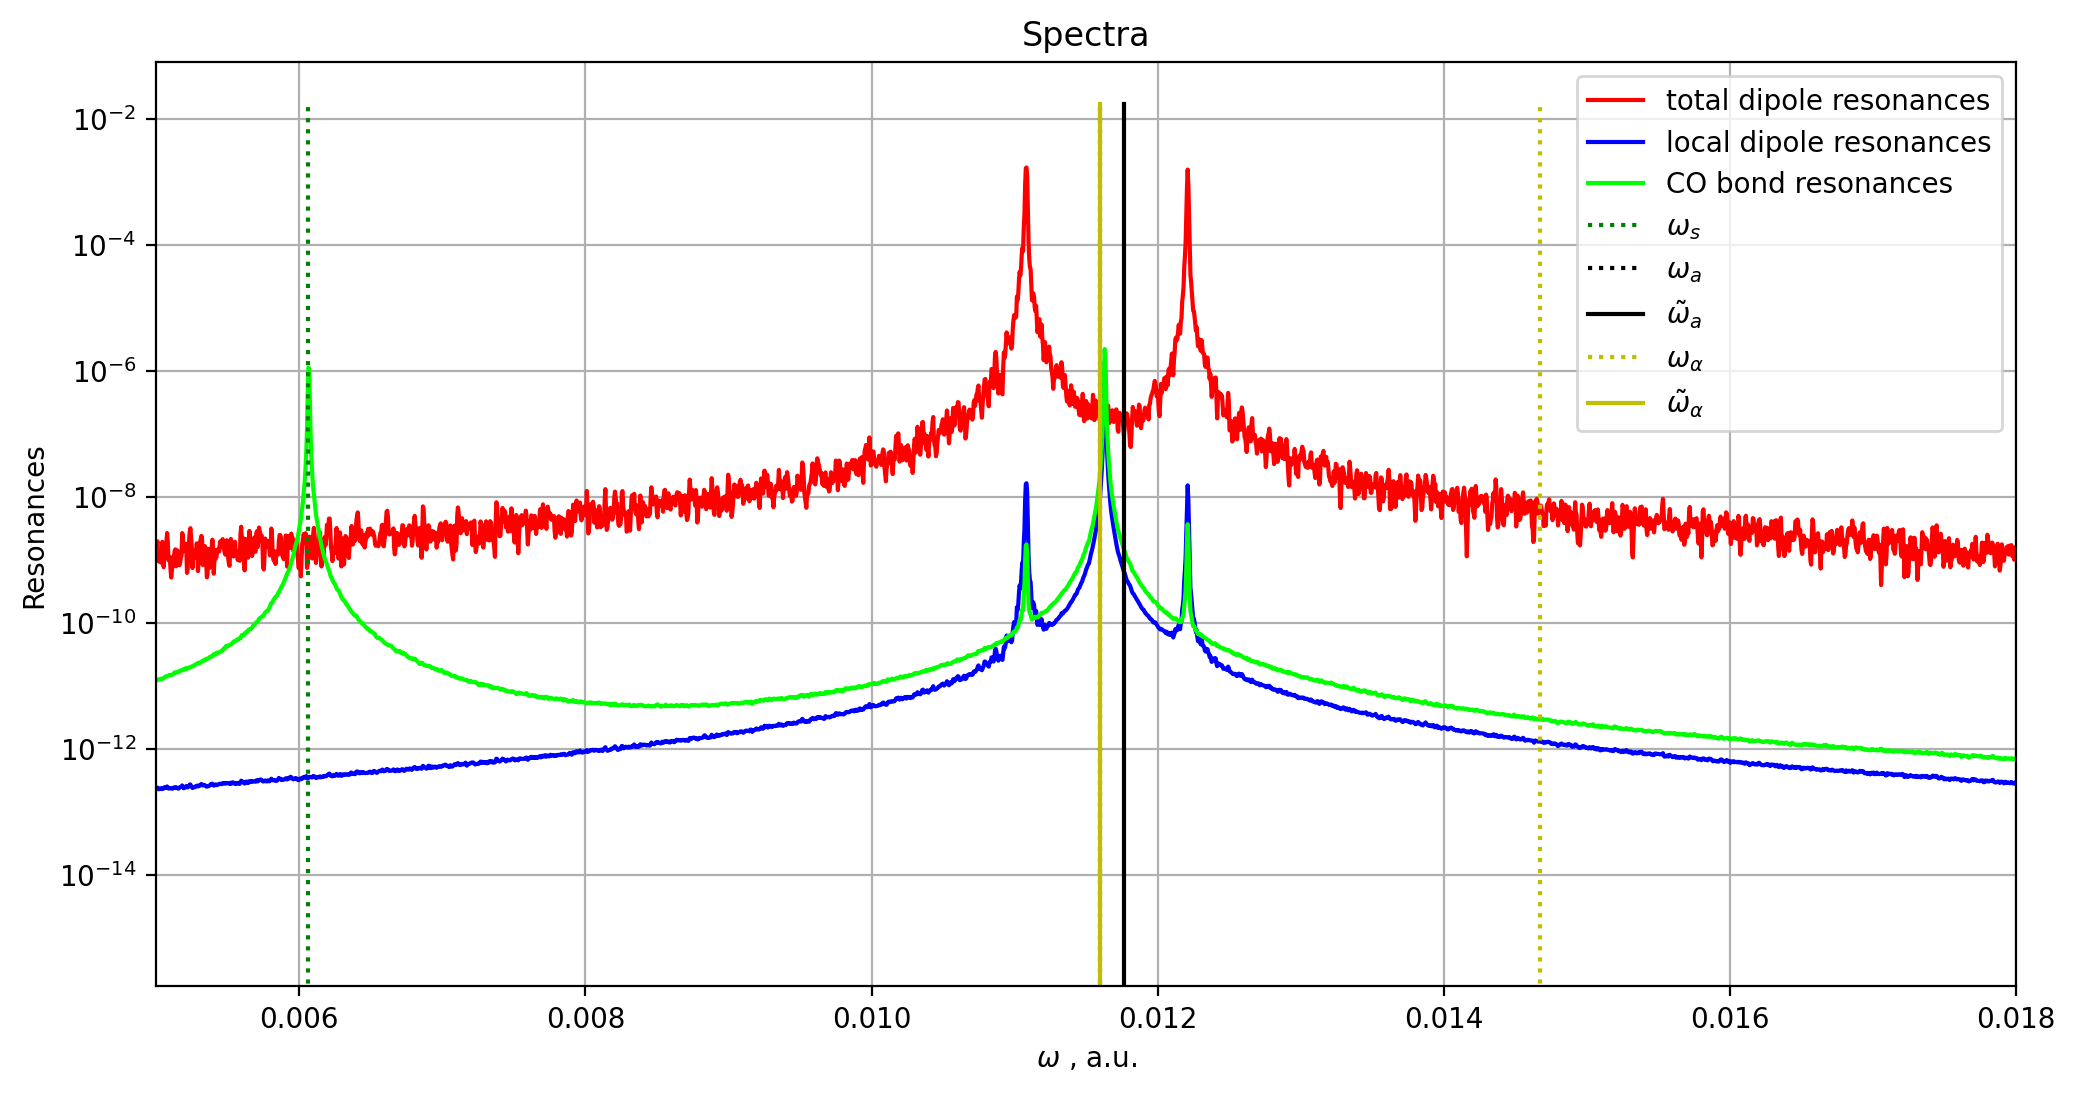

In [9]:
# todo: explore "large" N features numerically for cavity on resonance.
# todo: run your simulations
# Variable (recommended) Simulation parameters to explore 
n_molecules = 320 # number of CO2 molecules in ensemble
kBT_ensemble = 0.001 # [H] temperature (should be related to vibrational modes)
n_timesteps = 300000 # > 100000 number of timesteps to propagation

lambda_alpha = 0.015 # cavity coupling constant
omega_alpha =  0.014672 # cavity resonance frequency (take e.g. resonance suggestions below)

# initialize MD simulation
print("Simulation started ... ")
molecules = VSCSim(n_molecules, kBT_ensemble ,n_timesteps, lambda_alpha, omega_alpha)

# run MD simulation
start = timer()
for i in range(n_timesteps):
    molecules.classic_propagation_T(i)
end = timer()    
print("elapsed time for simulation, without analysis: ",end - start)

# output data
data = data_ana(molecules)
#data.plot_trajectories()
data.plot_spectra()

# A10.4
We notice that the intensities of local (!) Rabi splitting (lower and upper polariton) decrease with increasing number of molecules. This can for example seen when comparing simulations for $N = 20$, $kBT= 0.001$, $\lambda=0.06$, $\omega_\alpha=\frac{\omega_a}{\gamma}= 0.014672$ with $N = 320$, $kBT= 0.001$, $\lambda=0.015$, $\omega_\alpha=\frac{\omega_a}{\gamma}= 0.014672$.

This implies that for a macroscopic amount of molecuels under collective VSC ($N\gg 1$), vanishingly small local changes on a single molecular level are expected. In other words, they all vibrate at the bare matter frequencies $\omega_a$ and $\omega_s$. Thus one would expect no chemical changes under collective VSC, despite the presence of a collective Rabi splitting, which is determined by the fluctuations of the total dipole of the ensemble under VSC! Can we resolve this mystery? See lecture on polarization / spin glass.  


# Open research questions (Not expected that you try! Non-trivial!)
## The following questions have not yet been investigated with this MD code:

What is the role of thermal fluctuations / thermal energy in the given setup under VSC?

What happens for an ensemble of charged molecules, i.e., when changing $Z_e$?

What about non-adiabatic coupling between ground- and excitedstate PES?

## Going beyond the scope of this simulation:

What happens to the refractive index in the condensed phase? For example, is the Clausius-Mossotti relation applicable or how should it be modified?

What is the role of anharmonicity / a complex electronic structure?  

What is the role of quantum (vacuum or thermal) fluctuations? 
